![](https://static.wixstatic.com/media/4205be_693bbdf8070b461186014060ec420cc7~mv2.jpg/v1/fill/w_568,h_386,al_c,q_80,usm_0.66_1.00_0.01,enc_avif,quality_auto/4205be_693bbdf8070b461186014060ec420cc7~mv2.jpg)

# 1. Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import os
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import cv2
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
from tqdm import tqdm 

# Magic command for displaying plots in Jupyter notebooks
%matplotlib inline

# 2. Defining Dataset Paths  

In [4]:
train_dir = r"D:\môn AI\EmotionDataset_split\train"
test_dir = r"D:\môn AI\EmotionDataset_split\test"

# 3- EDA

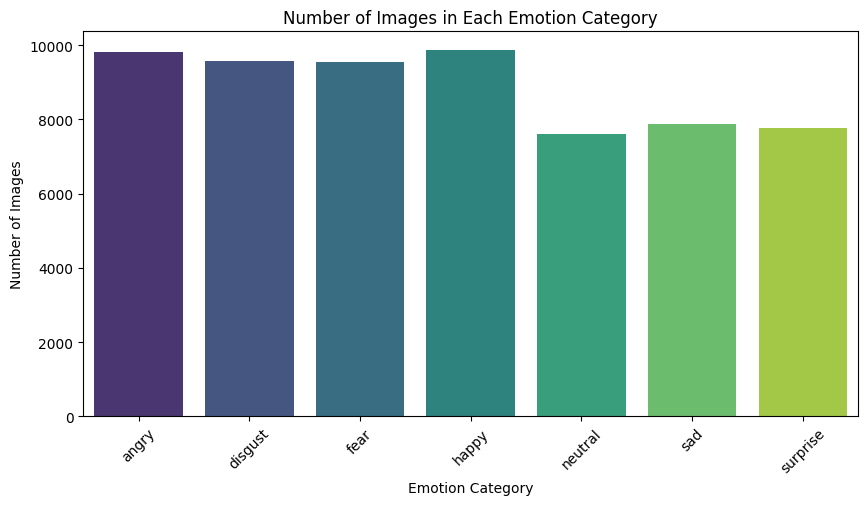

In [5]:
categories = os.listdir(train_dir)



image_counts = {category: len(os.listdir(os.path.join(train_dir, category))) for category in categories}



plt.figure(figsize=(10, 5))

sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()), palette="viridis")

plt.xlabel("Emotion Category")

plt.ylabel("Number of Images")

plt.title("Number of Images in Each Emotion Category")

plt.xticks(rotation=45)

plt.show()

In [ ]:

# Displaying sample images from each category
categories = os.listdir(train_dir)

plt.figure(figsize=(10, 6))

for i, category in enumerate(categories):
    category_path = os.path.join(train_dir, category)
    image_path = os.path.join(category_path, os.listdir(category_path)[0])  # Get first image
    
    # Sử dụng PIL
    image = Image.open(image_path).convert('L')  # Đọc và chuyển đổi sang ảnh grayscale
    
    # Chuyển đổi sang numpy array để hiển thị với matplotlib
    image_array = np.array(image)
    
    plt.subplot(2, 4, i+1)
    plt.imshow(image_array, cmap='gray')
    plt.title(category)
    plt.axis('off')

plt.tight_layout()
plt.show()


# 4. Data Augmentation and Preprocessing  

In [6]:
# Define the custom dataset class
train_transforms = transforms.Compose([
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Shift image horizontally and vertically by 10%
    transforms.RandomHorizontalFlip(),                         # Flip image horizontally
    transforms.ToTensor()                                        # Convert image to tensor and normalize [0,1]
])

test_transforms = transforms.Compose([
    transforms.ToTensor()
])


# 5. Creating Data Generators  

In [7]:
# Custom Dataset class for loading images
class EmotionDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.classes = os.listdir(directory)
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.images = []
        self.labels = []
        self.class_counts = {cls_name: 0 for cls_name in self.classes}
        
        for cls_name in self.classes:
            cls_dir = os.path.join(directory, cls_name)
            img_names = os.listdir(cls_dir)
            self.class_counts[cls_name] = len(img_names)
            
            for img_name in img_names:
                self.images.append(os.path.join(cls_dir, img_name))
                self.labels.append(self.class_to_idx[cls_name])
        
        # Hiển thị thông tin số lượng ảnh
        total_images = sum(self.class_counts.values())
        print(f"Found {total_images} images belonging to {len(self.classes)} classes.")
        
        # In ra chi tiết từng class
        for cls_name, count in self.class_counts.items():
            print(f"  - {cls_name}: {count} images")
                
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Tạo datasets
print("Training/Validation dataset:")
train_val_dataset = EmotionDataset(train_dir, transform=train_transforms)

# Chia dataset thành train và validation
train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
training_dataset, validation_dataset = torch.utils.data.random_split(train_val_dataset, [train_size, val_size])

print(f"  - Training samples: {len(training_dataset)}")
print(f"  - Validation samples: {len(validation_dataset)}")

print("\nTest dataset:")
test_dataset = EmotionDataset(test_dir, transform=test_transforms)

# Tạo data loaders
train_generator = DataLoader(training_dataset, batch_size=64, shuffle=True)
validation_generator = DataLoader(validation_dataset, batch_size=64, shuffle=False)
test_generator = DataLoader(test_dataset, batch_size=64, shuffle=False)

Training/Validation dataset:
Found 62085 images belonging to 7 classes.
  - angry: 9820 images
  - disgust: 9580 images
  - fear: 9557 images
  - happy: 9879 images
  - neutral: 7616 images
  - sad: 7868 images
  - surprise: 7765 images
  - Training samples: 49668
  - Validation samples: 12417

Test dataset:
Found 15519 images belonging to 7 classes.
  - angry: 2455 images
  - disgust: 2395 images
  - fear: 2389 images
  - happy: 2469 images
  - neutral: 1904 images
  - sad: 1966 images
  - surprise: 1941 images


# 6. Building the CNN Model 

In [8]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionCNN, self).__init__()
        
        # --- CÁC LỚP TÍCH CHẬP GIỮ NGUYÊN ---
        # Block 1
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        
        # Block 2
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)
        
        # Block 3
        self.conv3 = nn.Conv2d(128, 512, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(512)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.25)
        
        # Block 4
        self.conv4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout4 = nn.Dropout(0.25)
        
        # --- CÁC LỚP KẾT NỐI ĐẦY ĐỦ (DENSE LAYERS) ---
        
        # <<< THAY ĐỔI QUAN TRỌNG Ở ĐÂY >>>
        # Kích thước đầu vào của lớp fc1 được cập nhật cho ảnh 112x112
        # Kích thước sau 4 lớp pooling: 112 -> 56 -> 28 -> 14 -> 7.
        # Kích thước vector phẳng = 512 (kênh) * 7 * 7 = 25088
        self.fc1 = nn.Linear(512 * 7 * 7, 256)
        
        self.bn5 = nn.BatchNorm1d(256)
        self.relu5 = nn.ReLU()
        self.dropout5 = nn.Dropout(0.25)
        
        self.fc2 = nn.Linear(256, 512)
        self.bn6 = nn.BatchNorm1d(512)
        self.relu6 = nn.ReLU()
        self.dropout6 = nn.Dropout(0.25)
        
        # Output layer
        self.fc3 = nn.Linear(512, num_classes)
        
    
    def forward(self, x):
        # --- LUỒNG DỮ LIỆU ĐI TIẾP VẪN GIỮ NGUYÊN ---
        # Conv block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Conv block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Conv block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Conv block 4
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        x = self.dropout4(x)
        
        # Flatten
        x = torch.flatten(x, 1)
        
        # Dense layers
        x = self.fc1(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.dropout5(x)
        
        x = self.fc2(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.dropout6(x)
        
        # Output layer
        x = self.fc3(x)
        
        return x

# --- CÁC PHẦN KHỞI TẠO KHÁC GIỮ NGUYÊN ---
# Khởi tạo mô hình
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EmotionCNN(num_classes=7).to(device)

# Định nghĩa optimizer và loss function
# Thêm L2 regularization thông qua weight_decay
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

# In ra cấu trúc model để kiểm tra
print(model)

EmotionCNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.25, inplace=False)
  (conv4): Conv2d(512, 512, kernel_size

In [9]:
import torch

# Set the device to GPU (assuming you want to use the first GPU)
device = torch.device("cuda:0")  # Change to "cuda:1" for the second GPU, etc.

# Check if the GPU is available
if not torch.cuda.is_available():
    raise RuntimeError("CUDA is not available. Please check your installation.")

# Create a tensor on the GPU
tensor = torch.tensor([1.0, 2.0, 3.0], device=device)

# Perform an operation (e.g., adding 2)
result = tensor + 2

# Print the result
print("Result:", result)


Result: tensor([3., 4., 5.], device='cuda:0')


# 7. Training the Model  

--- BẮT ĐẦU QUÁ TRÌNH HUẤN LUYỆN ---


Epoch 1/100 [Training]:   0%|          | 0/777 [00:00<?, ?it/s]


Epoch 1/100: Train Loss: 0.6322, Train Acc: 0.7975 | Val Loss: 3.5740, Val Acc: 0.3214
   -> Validation loss cải thiện. Lưu model tại 'best_model.pth'



Epoch 2/100: Train Loss: 0.1540, Train Acc: 0.9514 | Val Loss: 1.9916, Val Acc: 0.4339
   -> Validation loss cải thiện. Lưu model tại 'best_model.pth'



Epoch 3/100: Train Loss: 0.1023, Train Acc: 0.9663 | Val Loss: 0.6385, Val Acc: 0.7672
   -> Validation loss cải thiện. Lưu model tại 'best_model.pth'



Epoch 4/100: Train Loss: 0.0771, Train Acc: 0.9769 | Val Loss: 0.1634, Val Acc: 0.9465
   -> Validation loss cải thiện. Lưu model tại 'best_model.pth'



Epoch 5/100: Train Loss: 0.0615, Train Acc: 0.9831 | Val Loss: 0.1537, Val Acc: 0.9451
   -> Validation loss cải thiện. Lưu model tại 'best_model.pth'



Epoch 6/100: Train Loss: 0.0568, Train Acc: 0.9850 | Val Loss: 0.0278, Val Acc: 0.9944
   -> Validation loss cải thiện. Lưu model tại 'best_model.pth'



Epoch 7/100: Train Loss: 0.0521, Train Acc: 0.9875 | Val Loss: 0.1719, Val Acc: 0.9465
   -> Validation loss không cải thiện. Patience: 1/20



Epoch 8/100: Train Loss: 0.0508, Train Acc: 0.9888 | Val Loss: 0.3579, Val Acc: 0.8772
   -> Validation loss không cải thiện. Patience: 2/20



Epoch 9/100: Train Loss: 0.0638, Train Acc: 0.9864 | Val Loss: 0.8808, Val Acc: 0.7201
   -> Validation loss không cải thiện. Patience: 3/20



Epoch 10/100: Train Loss: 0.0542, Train Acc: 0.9904 | Val Loss: 0.5654, Val Acc: 0.8153
   -> Validation loss không cải thiện. Patience: 4/20



Epoch 11/100: Train Loss: 0.0581, Train Acc: 0.9907 | Val Loss: 0.1091, Val Acc: 0.9706
   -> Validation loss không cải thiện. Patience: 5/20



Epoch 12/100: Train Loss: 0.0565, Train Acc: 0.9928 | Val Loss: 0.2532, Val Acc: 0.9059
   -> Validation loss không cải thiện. Patience: 6/20



Epoch 13/100: Train Loss: 0.0603, Train Acc: 0.9930 | Val Loss: 0.1550, Val Acc: 0.9671
   -> Validation loss không cải thiện. Patience: 7/20



Epoch 14/100: Train Loss: 0.0600, Train Acc: 0.9938 | Val Loss: 0.5496, Val Acc: 0.8436
   -> Validation loss không cải thiện. Patience: 8/20



Epoch 15/100: Train Loss: 0.0591, Train Acc: 0.9945 | Val Loss: 0.3940, Val Acc: 0.8655
   -> Validation loss không cải thiện. Patience: 9/20



Epoch 16/100: Train Loss: 0.0570, Train Acc: 0.9947 | Val Loss: 0.0604, Val Acc: 0.9923
   -> Validation loss không cải thiện. Patience: 10/20



Epoch 17/100: Train Loss: 0.0539, Train Acc: 0.9960 | Val Loss: 0.1666, Val Acc: 0.9706
   -> Validation loss không cải thiện. Patience: 11/20



Epoch 18/100: Train Loss: 0.0497, Train Acc: 0.9970 | Val Loss: 0.2951, Val Acc: 0.8961
   -> Validation loss không cải thiện. Patience: 12/20



Epoch 19/100: Train Loss: 0.0508, Train Acc: 0.9962 | Val Loss: 0.0635, Val Acc: 0.9921
   -> Validation loss không cải thiện. Patience: 13/20



Epoch 20/100: Train Loss: 0.0477, Train Acc: 0.9973 | Val Loss: 0.1407, Val Acc: 0.9604
   -> Validation loss không cải thiện. Patience: 14/20



Epoch 21/100: Train Loss: 0.0439, Train Acc: 0.9980 | Val Loss: 0.2416, Val Acc: 0.9211
   -> Validation loss không cải thiện. Patience: 15/20



Epoch 22/100: Train Loss: 0.0469, Train Acc: 0.9972 | Val Loss: 0.0252, Val Acc: 0.9999
   -> Validation loss cải thiện. Lưu model tại 'best_model.pth'



Epoch 23/100: Train Loss: 0.0414, Train Acc: 0.9986 | Val Loss: 0.1323, Val Acc: 0.9516
   -> Validation loss không cải thiện. Patience: 1/20



Epoch 24/100: Train Loss: 0.0453, Train Acc: 0.9975 | Val Loss: 0.0252, Val Acc: 0.9996
   -> Validation loss cải thiện. Lưu model tại 'best_model.pth'



Epoch 25/100: Train Loss: 0.0412, Train Acc: 0.9986 | Val Loss: 0.0356, Val Acc: 0.9975
   -> Validation loss không cải thiện. Patience: 1/20



Epoch 26/100: Train Loss: 0.0470, Train Acc: 0.9968 | Val Loss: 0.0262, Val Acc: 0.9997
   -> Validation loss không cải thiện. Patience: 2/20



Epoch 27/100: Train Loss: 0.0397, Train Acc: 0.9990 | Val Loss: 0.0520, Val Acc: 0.9944
   -> Validation loss không cải thiện. Patience: 3/20



Epoch 28/100: Train Loss: 0.0418, Train Acc: 0.9986 | Val Loss: 0.0303, Val Acc: 0.9992
   -> Validation loss không cải thiện. Patience: 4/20



Epoch 29/100: Train Loss: 0.0406, Train Acc: 0.9988 | Val Loss: 0.0214, Val Acc: 0.9999
   -> Validation loss cải thiện. Lưu model tại 'best_model.pth'



Epoch 30/100: Train Loss: 0.0406, Train Acc: 0.9988 | Val Loss: 0.0371, Val Acc: 0.9979
   -> Validation loss không cải thiện. Patience: 1/20



Epoch 31/100: Train Loss: 0.0464, Train Acc: 0.9969 | Val Loss: 0.0217, Val Acc: 0.9998
   -> Validation loss không cải thiện. Patience: 2/20



Epoch 32/100: Train Loss: 0.0392, Train Acc: 0.9991 | Val Loss: 0.0257, Val Acc: 0.9987
   -> Validation loss không cải thiện. Patience: 3/20



Epoch 33/100: Train Loss: 0.0430, Train Acc: 0.9980 | Val Loss: 0.0212, Val Acc: 0.9999
   -> Validation loss cải thiện. Lưu model tại 'best_model.pth'



Epoch 34/100: Train Loss: 0.0391, Train Acc: 0.9992 | Val Loss: 0.0209, Val Acc: 0.9996
   -> Validation loss cải thiện. Lưu model tại 'best_model.pth'



Epoch 35/100: Train Loss: 0.0437, Train Acc: 0.9976 | Val Loss: 0.0178, Val Acc: 0.9996
   -> Validation loss cải thiện. Lưu model tại 'best_model.pth'



Epoch 36/100: Train Loss: 0.0394, Train Acc: 0.9991 | Val Loss: 0.0176, Val Acc: 0.9998
   -> Validation loss cải thiện. Lưu model tại 'best_model.pth'



Epoch 37/100: Train Loss: 0.0411, Train Acc: 0.9986 | Val Loss: 0.0323, Val Acc: 0.9989
   -> Validation loss không cải thiện. Patience: 1/20



Epoch 38/100: Train Loss: 0.0419, Train Acc: 0.9982 | Val Loss: 0.0226, Val Acc: 0.9994
   -> Validation loss không cải thiện. Patience: 2/20



Epoch 39/100: Train Loss: 0.0412, Train Acc: 0.9985 | Val Loss: 0.0200, Val Acc: 0.9998
   -> Validation loss không cải thiện. Patience: 3/20



Epoch 40/100: Train Loss: 0.0372, Train Acc: 0.9995 | Val Loss: 0.0174, Val Acc: 0.9999
   -> Validation loss cải thiện. Lưu model tại 'best_model.pth'



Epoch 41/100: Train Loss: 0.0407, Train Acc: 0.9987 | Val Loss: 0.0151, Val Acc: 1.0000
   -> Validation loss cải thiện. Lưu model tại 'best_model.pth'



Epoch 42/100: Train Loss: 0.0391, Train Acc: 0.9989 | Val Loss: 0.0155, Val Acc: 0.9998
   -> Validation loss không cải thiện. Patience: 1/20



Epoch 43/100: Train Loss: 0.0405, Train Acc: 0.9986 | Val Loss: 0.0163, Val Acc: 1.0000
   -> Validation loss không cải thiện. Patience: 2/20



Epoch 44/100: Train Loss: 0.0387, Train Acc: 0.9991 | Val Loss: 0.0220, Val Acc: 0.9997
   -> Validation loss không cải thiện. Patience: 3/20



Epoch 45/100: Train Loss: 0.0411, Train Acc: 0.9983 | Val Loss: 0.0192, Val Acc: 0.9999
   -> Validation loss không cải thiện. Patience: 4/20



Epoch 46/100: Train Loss: 0.0429, Train Acc: 0.9984 | Val Loss: 0.0313, Val Acc: 0.9987
   -> Validation loss không cải thiện. Patience: 5/20



Epoch 47/100: Train Loss: 0.0400, Train Acc: 0.9989 | Val Loss: 0.0238, Val Acc: 0.9998
   -> Validation loss không cải thiện. Patience: 6/20



Epoch 48/100: Train Loss: 0.0390, Train Acc: 0.9990 | Val Loss: 0.0202, Val Acc: 0.9998
   -> Validation loss không cải thiện. Patience: 7/20



Epoch 49/100: Train Loss: 0.0407, Train Acc: 0.9986 | Val Loss: 0.0184, Val Acc: 0.9996
   -> Validation loss không cải thiện. Patience: 8/20



Epoch 50/100: Train Loss: 0.0412, Train Acc: 0.9985 | Val Loss: 0.0183, Val Acc: 1.0000
   -> Validation loss không cải thiện. Patience: 9/20



Epoch 51/100: Train Loss: 0.0404, Train Acc: 0.9986 | Val Loss: 0.0340, Val Acc: 0.9959
   -> Validation loss không cải thiện. Patience: 10/20



Epoch 52/100: Train Loss: 0.0392, Train Acc: 0.9990 | Val Loss: 0.0142, Val Acc: 0.9998
   -> Validation loss cải thiện. Lưu model tại 'best_model.pth'



Epoch 53/100: Train Loss: 0.0391, Train Acc: 0.9990 | Val Loss: 0.0205, Val Acc: 0.9996
   -> Validation loss không cải thiện. Patience: 1/20



Epoch 54/100: Train Loss: 0.0387, Train Acc: 0.9990 | Val Loss: 0.0180, Val Acc: 0.9998
   -> Validation loss không cải thiện. Patience: 2/20



Epoch 55/100: Train Loss: 0.0400, Train Acc: 0.9988 | Val Loss: 0.0153, Val Acc: 0.9999
   -> Validation loss không cải thiện. Patience: 3/20



Epoch 56/100: Train Loss: 0.0383, Train Acc: 0.9992 | Val Loss: 0.0227, Val Acc: 0.9986
   -> Validation loss không cải thiện. Patience: 4/20



Epoch 57/100: Train Loss: 0.0471, Train Acc: 0.9967 | Val Loss: 0.0175, Val Acc: 1.0000
   -> Validation loss không cải thiện. Patience: 5/20



Epoch 58/100: Train Loss: 0.0399, Train Acc: 0.9987 | Val Loss: 0.0264, Val Acc: 0.9999
   -> Validation loss không cải thiện. Patience: 6/20



Epoch 59/100: Train Loss: 0.0395, Train Acc: 0.9990 | Val Loss: 0.0301, Val Acc: 0.9997
   -> Validation loss không cải thiện. Patience: 7/20



Epoch 60/100: Train Loss: 0.0396, Train Acc: 0.9989 | Val Loss: 0.0169, Val Acc: 1.0000
   -> Validation loss không cải thiện. Patience: 8/20



Epoch 61/100: Train Loss: 0.0381, Train Acc: 0.9991 | Val Loss: 0.0240, Val Acc: 0.9993
   -> Validation loss không cải thiện. Patience: 9/20



Epoch 62/100: Train Loss: 0.0404, Train Acc: 0.9987 | Val Loss: 0.0167, Val Acc: 0.9998
   -> Validation loss không cải thiện. Patience: 10/20



Epoch 63/100: Train Loss: 0.0404, Train Acc: 0.9985 | Val Loss: 0.0153, Val Acc: 0.9999
   -> Validation loss không cải thiện. Patience: 11/20



Epoch 64/100: Train Loss: 0.0395, Train Acc: 0.9990 | Val Loss: 0.0177, Val Acc: 0.9999
   -> Validation loss không cải thiện. Patience: 12/20



Epoch 65/100: Train Loss: 0.0384, Train Acc: 0.9991 | Val Loss: 0.0371, Val Acc: 0.9974
   -> Validation loss không cải thiện. Patience: 13/20



Epoch 66/100: Train Loss: 0.0415, Train Acc: 0.9981 | Val Loss: 0.0212, Val Acc: 0.9995
   -> Validation loss không cải thiện. Patience: 14/20



Epoch 67/100: Train Loss: 0.0390, Train Acc: 0.9988 | Val Loss: 0.0363, Val Acc: 0.9994
   -> Validation loss không cải thiện. Patience: 15/20



Epoch 68/100: Train Loss: 0.0392, Train Acc: 0.9989 | Val Loss: 0.0202, Val Acc: 0.9998
   -> Validation loss không cải thiện. Patience: 16/20



Epoch 69/100: Train Loss: 0.0404, Train Acc: 0.9986 | Val Loss: 0.0193, Val Acc: 0.9995
   -> Validation loss không cải thiện. Patience: 17/20



Epoch 70/100: Train Loss: 0.0381, Train Acc: 0.9990 | Val Loss: 0.0236, Val Acc: 0.9998
   -> Validation loss không cải thiện. Patience: 18/20



Epoch 71/100: Train Loss: 0.0418, Train Acc: 0.9984 | Val Loss: 0.0233, Val Acc: 1.0000
   -> Validation loss không cải thiện. Patience: 19/20



Epoch 72/100: Train Loss: 0.0396, Train Acc: 0.9987 | Val Loss: 0.0142, Val Acc: 1.0000
   -> Validation loss không cải thiện. Patience: 20/20

--- DỪNG SỚM tại epoch 72 do không cải thiện sau 20 epochs. ---

--- KẾT THÚC QUÁ TRÌNH HUẤN LUYỆN ---
Tải lại model tốt nhất từ 'best_model.pth' với Val Loss: 0.0142

--- VẼ ĐỒ THỊ KẾT QUẢ HUẤN LUYỆN ---


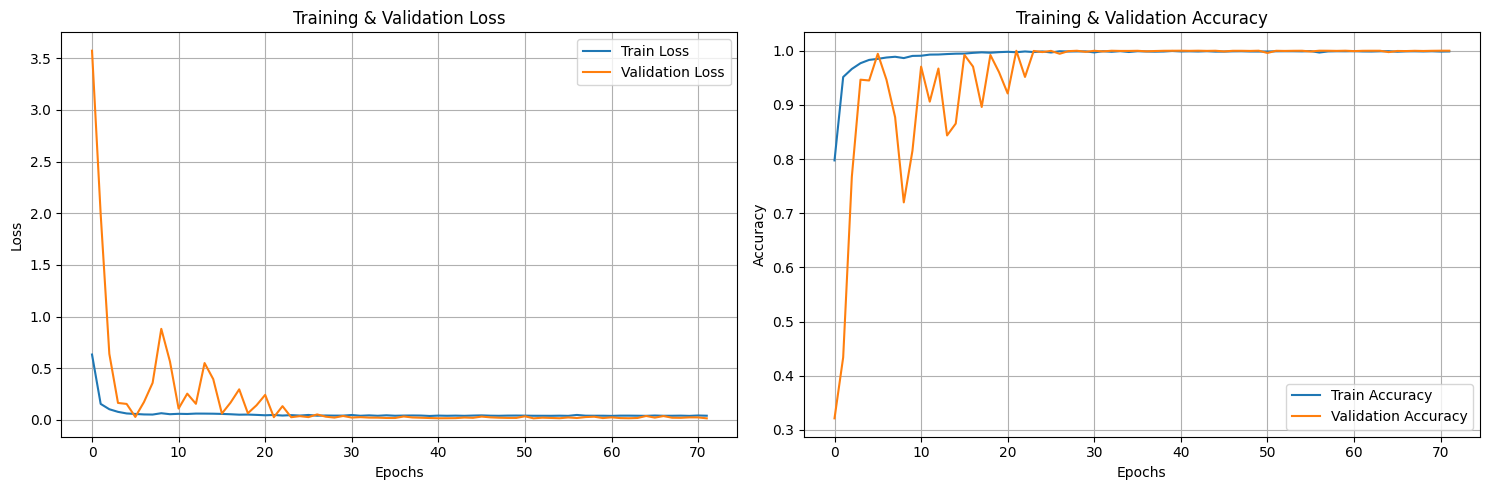

In [ ]:
# Thiết lập số epoch để huấn luyện
num_epochs = 100  # Bạn có thể điều chỉnh số epoch này

# <<< CẢI TIẾN: Thiết lập các tham số cho Early Stopping >>>
patience = 20  # Số epoch kiên nhẫn chờ trước khi dừng
patience_counter = 0
best_val_loss = float('inf') # Khởi tạo loss tốt nhất là vô cùng lớn
best_model_path = 'best_model.pth' # Đường dẫn lưu model tốt nhất

# History để lưu kết quả
history = {
    "train_loss": [],
    "val_loss": [],
    "train_accuracy": [],
    "val_accuracy": []
}

print("--- BẮT ĐẦU QUÁ TRÌNH HUẤN LUYỆN ---")

# Vòng lặp huấn luyện chính
for epoch in range(num_epochs):
    
    # --- PHA HUẤN LUYỆN ---
    model.train()
    
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    train_loop = tqdm(train_generator, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=False)
    
    for images_batch, labels_batch in train_loop:
        images_batch = images_batch.to(device)
        labels_batch = labels_batch.to(device)
        
        optimizer.zero_grad()
        outputs_batch = model(images_batch)
        loss = criterion(outputs_batch, labels_batch)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * labels_batch.size(0)
        preds = torch.argmax(outputs_batch, dim=1)
        correct_train += (preds == labels_batch).sum().item()
        total_train += labels_batch.size(0)

        train_loop.set_postfix(loss=loss.item())

    train_loss = running_train_loss / total_train
    train_accuracy = correct_train / total_train
    
    
    # --- PHA ĐÁNH GIÁ TRÊN TẬP VALIDATION ---
    model.eval()
    
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    val_loop = tqdm(validation_generator, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=False)
    
    with torch.no_grad():
        for images_batch, labels_batch in val_loop:
            images_batch = images_batch.to(device)
            labels_batch = labels_batch.to(device)
            
            outputs_batch = model(images_batch)
            loss = criterion(outputs_batch, labels_batch)
            
            running_val_loss += loss.item() * labels_batch.size(0)
            preds = torch.argmax(outputs_batch, dim=1)
            correct_val += (preds == labels_batch).sum().item()
            total_val += labels_batch.size(0)

            val_loop.set_postfix(loss=loss.item())
            
    val_loss = running_val_loss / total_val
    val_accuracy = correct_val / total_val
    
    # Lưu kết quả
    history["train_loss"].append(train_loss)
    history["train_accuracy"].append(train_accuracy)
    history["val_loss"].append(val_loss)
    history["val_accuracy"].append(val_accuracy)
    
    # In kết quả tổng kết của epoch
    print(f"\nEpoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    # <<< CẢI TIẾN: Logic của Early Stopping >>>
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Lưu lại model tốt nhất
        torch.save(model.state_dict(), best_model_path)
        print(f"   -> Validation loss cải thiện. Lưu model tại '{best_model_path}'")
    else:
        patience_counter += 1
        print(f"   -> Validation loss không cải thiện. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print(f"\n--- DỪNG SỚM tại epoch {epoch+1} do không cải thiện sau {patience} epochs. ---")
            break # Thoát khỏi vòng lặp huấn luyện

print("\n--- KẾT THÚC QUÁ TRÌNH HUẤN LUYỆN ---")

# <<< CẢI TIẾN: Tải lại trọng số của model tốt nhất đã lưu >>>
print(f"Tải lại model tốt nhất từ '{best_model_path}' với Val Loss: {best_val_loss:.4f}")
model.load_state_dict(torch.load(best_model_path))
# <<< CẢI TIẾN: Vẽ đồ thị Loss và Accuracy >>>
print("\n--- VẼ ĐỒ THỊ KẾT QUẢ HUẤN LUYỆN ---")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Đồ thị Loss
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.set_title('Training & Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Đồ thị Accuracy
ax2.plot(history['train_accuracy'], label='Train Accuracy')
ax2.plot(history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Training & Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()